In [1]:
from importlib import reload
from rlxutils import subplots
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch

import omegaconf
from loguru import logger
from omegaconf import DictConfig, OmegaConf
import hydra
from progressbar import progressbar as pbar

from earthtext.datamodules import chipmultilabel
from earthtext.models import osmencoder
from importlib import reload
reload(chipmultilabel)
reload(osmencoder)

<module 'earthtext.models.osmencoder' from '/home/ubuntu/earth-text/src/earthtext/models/osmencoder.py'>

## setup dataloader

In [2]:
#conf = OmegaConf.load("../../configs/osmencoder-abs-logrsme-1epoch.yaml")
conf = OmegaConf.load("../../configs/naip-osmencoder.yaml")
dl = hydra.utils.instantiate(conf.dataloader)

2024-05-17 00:43:52.882 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-17 00:43:52.884 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read train split with 72268 chip files (out of 72268)
2024-05-17 00:43:52.884 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-17 00:43:54.845 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-17 00:43:54.847 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:109 - read val split with 14770 chip files (out of 14770)
2024-05-17 00:43:54.848 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:114 - max cache size is -1
2024-05-17 00:43:56.873 | INFO     | earthtext.datamodules.components.chipmultilabel:__init__:96 - using embeddings found in metadata file
2024-05-17 00:43:56.876 | INFO     

In [3]:
import pickle
with open("/opt/data/california-naip-chips/california-naip-chips-100k_metadata_embeddings_meansstdevs.pkl", "rb") as f:
    z = pickle.load(f)

In [4]:
b = dl.train_dataset[0]

In [5]:
b.keys()

dict_keys(['multilabel', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

## setup model and optimizer

In [6]:
conf = OmegaConf.load("../../configs/naip-osmencoder.yaml")

eps = 1e-5


loss_funcs = {
    'rmse': lambda a,b: torch.sqrt(torch.mean( (a - b)**2 )),
    'mse': lambda a,b: torch.mean( (a - b)**2 ),
    
}

dltrain = dl.train_dataloader()

m = hydra.utils.instantiate(conf.model)

optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)
#optimizer = torch.optim.RMSprop(m.parameters(), lr=1e-5)

loss_fn = loss_funcs[conf.training.loss]

dl.disable_chip_loading()

sum([np.product(p.shape) for p in m.parameters()]), conf.training.epochs

(21652224, 1)

In [7]:
len(m.osm_tags_indexes)

140

In [8]:
m.layers

Sequential(
  (0): Linear(in_features=420, out_features=4096, bias=True)
  (1): ReLU()
  (2): Linear(in_features=4096, out_features=4096, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4096, out_features=768, bias=True)
)

In [9]:
conf.training.loss

'rmse'

In [10]:
from datetime import datetime
models_folder = "/opt/data/models/"
embeddings_version = 'naip'
nowstr = datetime.today().strftime("%Y-%m-%d_%H:%M")
model_name = f"osm_emcoder__{embeddings_version}__trainedon_{nowstr}"
model_conf_fname = f"{models_folder}/{model_name}.yaml"
model_ckpt_fname = f"{models_folder}/{model_name}.ckpt"

In [11]:
model_name

'osm_emcoder__naip__trainedon_2024-05-17_00:44'

In [41]:
dl.disable_chip_loading()
dltrain = dl.train_dataloader()
dltrain.dataset.embeddings_normalization
len(dltrain)

9034

## train loop

In [13]:
optimizer = torch.optim.Adam(m.parameters(), lr=1e-5)


In [ ]:
n_epochs = conf.training.epochs
n_epochs = 1000

lossh = []
rmseh = []
for epoch in range(n_epochs):
    for step, batch in enumerate(dltrain):
        # extract data from batch
        t = batch['embedding']

        # run model
        o = m(batch)

        # compute losses (complex mse or rmse)
        loss_base = loss_fn(t,o)
        loss_reg = torch.sum(torch.stack([(p.abs().mean()) for p in m.parameters()]))

        rmse = loss_funcs['rmse'](t,o)        
        
        #loss_variance = torch.sqrt(torch.mean((t.std(axis=0) - o.std(axis=0))**2))
        output_stdev = (o.std(axis=0)+1e-5).mean()
        loss = loss_base + 10*loss_reg
        
        # backpropage and sigmoidupdate
        loss.backward()
        optimizer.step()
        
        # cosmetics
        lossn = loss.detach().cpu().numpy()
        rmsen = rmse.detach().cpu().numpy()
        lossh.append(lossn)
        rmseh.append(rmsen)
        psummary = np.mean([(p.abs().mean().detach().cpu().numpy()) for p in m.parameters()])    
        lossm = np.mean(lossh[-500:])
        rmsem = np.mean(rmseh[-500:])
        print(f"epoch {epoch:3} step {step:3d} loss {lossm:.5f} rmse {rmsem:.5f} params {loss_reg:.7f} output_stdev {output_stdev.detach().numpy():.5f}", end="\r")

        OmegaConf.save(conf, model_conf_fname)
        torch.save(m.state_dict(), model_ckpt_fname)
        
        #if loss < 0.5:
        #    print ("low loss!!")
        #    break
    #print()

In [15]:
len(m.osm_tags_names)

140

In [16]:
models_folder = "/opt/data/models/"

In [31]:
# save model
from datetime import datetime
models_folder = "/opt/data/models/"
embeddings_version = 'naip'
nowstr = datetime.today().strftime("%Y-%m-%d_%H:%M")
model_name = f"osm_emcoder__{embeddings_version}__trainedon_{nowstr}"
model_conf_fname = f"{models_folder}/{model_name}.yaml"
model_ckpt_fname = f"{models_folder}/{model_name}.ckpt"


OmegaConf.save(conf, model_conf_fname)
torch.save(m.state_dict(), model_ckpt_fname)

model_ckpt_fname

'/opt/data/models//osm_emcoder__naip__trainedon_2024-05-17_01:39.ckpt'

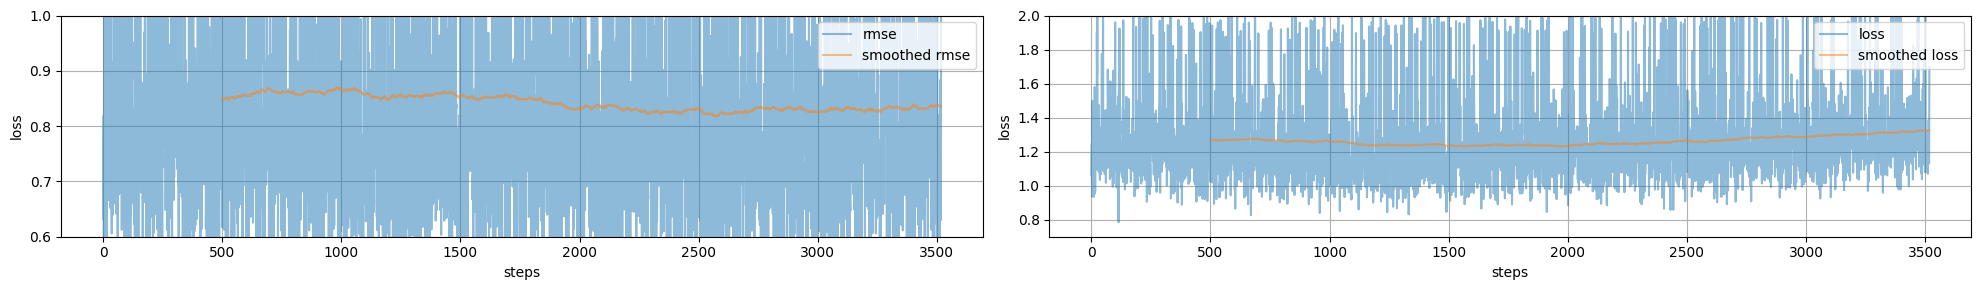

In [32]:
def ploth(h, name='loss', ylim=None, ax=None):
    lossp = pd.DataFrame(h, columns=[name])
    lossp[f'smoothed {name}'] = lossp[name].rolling(500).mean()
    lossp.plot(alpha=.5, ax=ax)
    plt.grid(); plt.xlabel("steps"); plt.ylabel("loss")
    if ylim is not None:
        plt.ylim(*ylim)
        
for ax,i in subplots(2, usizex=10):
    if i==0: ploth(np.r_[rmseh], name='rmse', ax=ax, ylim=(.6,1))
    if i==1: ploth(lossh, name='loss', ax=ax, ylim=(0.7,2))

In [33]:
o[-5:]

tensor([[-0.0846,  0.2330, -0.0122,  ...,  0.2375, -0.0696,  0.2253],
        [ 3.2543, -0.6857,  2.1353,  ..., -2.4115,  4.1002, -1.1031],
        [ 0.5559,  0.5520, -0.9361,  ...,  0.2110, -0.9184,  0.5659],
        [-0.2288,  0.0074,  0.2527,  ..., -0.1181, -0.0168, -0.2236],
        [ 0.1608, -0.4563,  0.5803,  ..., -0.5031,  0.7609, -0.4203]],
       grad_fn=<SliceBackward0>)

In [34]:
t[-5:]

tensor([[-0.6490,  0.3963,  0.5635,  ...,  0.0531,  0.6509, -0.7478],
        [-0.8219,  0.1053,  0.6867,  ..., -0.5993,  0.5916, -0.7846],
        [ 1.5479,  0.4910, -1.3956,  ..., -1.0302, -0.8726, -1.2505],
        [-0.1587, -0.3737,  0.6768,  ..., -0.8270,  0.7809, -0.4423],
        [-0.2069, -0.2350,  0.7170,  ..., -0.4328,  0.5416, -0.7703]])

## visualize targets vs predictions on random chips

In [35]:
b = next(iter(dl.test_dataloader()))
b.keys()

dict_keys(['multilabel', 'embedding', 'osm_strlabels', 'osm_ohearea', 'osm_ohecount', 'osm_ohelength'])

In [36]:
tr_targets = b['embedding'].numpy()[:16]
tr_predictions = m(b).detach().numpy()[:16]

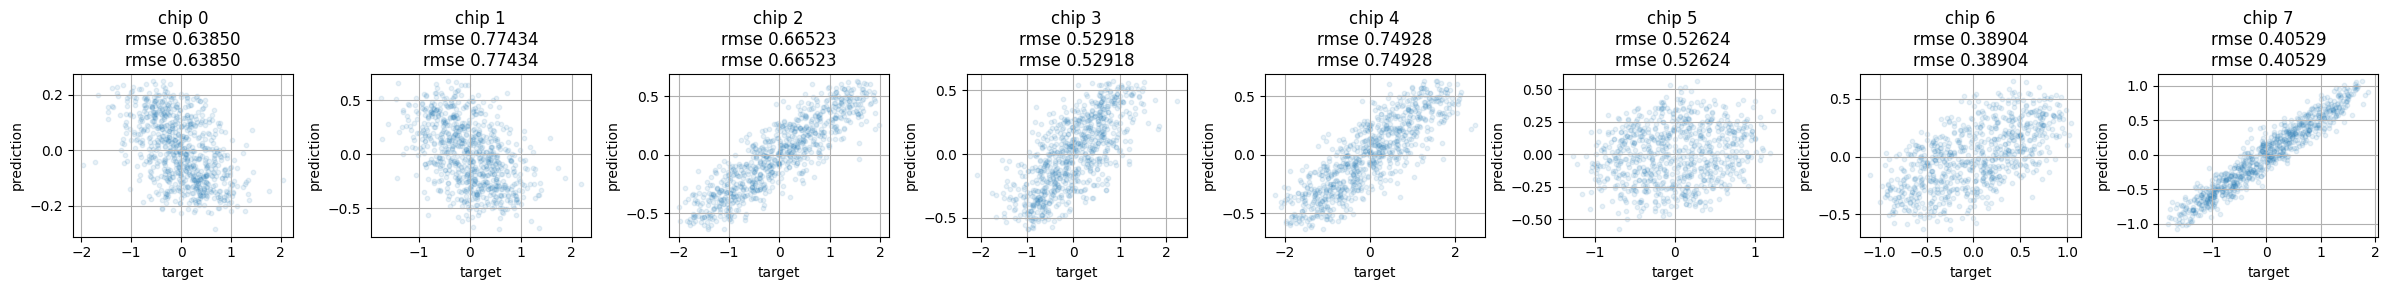

In [40]:
for ax,i in subplots(len(tr_targets), n_cols=8):
    idx = i
    t = tr_targets[idx]
    p = tr_predictions[idx]
    plt.scatter(t, p, alpha=.1, s=10)
    plt.grid()
    plt.xlabel("target")
    plt.ylabel("prediction")
    rmse = np.sqrt(np.mean ( (t-p)**2 ))
    logr = loss_funcs[conf.training.loss](torch.tensor(t),torch.tensor(p))
    plt.title(f"chip {idx}\nrmse {rmse:.5f}\n{conf.training.loss} {logr:.5f}")
    ta,tb = np.percentile(t, [1,99])
    pa,pb = np.percentile(p, [1,99])
    #plt.xlim(ta, tb)
    #plt.ylim(pa, pb)


## measure loss on full train,val,test datasets

In [24]:
def get_targets_and_predictions(dataloader):

    targets = []
    predictions = []
    inputs = []
    for batch in pbar(dataloader):
        t = batch['embedding']
        o = m(batch)
        x = m.make_input(batch)
    
        for ti in t.detach().numpy():
            targets.append(ti)
    
        for oi in o.detach().numpy():
            predictions.append(oi)

        for xi in x.detach().numpy():
            inputs.append(xi)
        
    targets = np.r_[targets]
    predictions = np.r_[predictions]
    inputs = np.r_[inputs]
    return targets, predictions, inputs

In [25]:
c = dl.normalizer.constants
for k in c['means'].keys():
    c['stdevs'][k][ np.abs(c['means'][k]<1e-4) & (c['stdevs'][k]<1e-4) ] = 1


In [26]:
dl.disable_chip_loading()
tr_targets, tr_predictions, tr_inputs = get_targets_and_predictions(dl.train_dataloader())

100% (9034 of 9034) |####################| Elapsed Time: 0:01:02 Time:  0:01:020005


In [27]:
ts_targets, ts_predictions, ts_inputs = get_targets_and_predictions(dl.test_dataloader())
val_targets, val_predictions, val_inputs = get_targets_and_predictions(dl.val_dataloader())

 71% (1539 of 2151) |##############      | Elapsed Time: 0:00:12 ETA:   0:00:04Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71f0ef270180>
Traceback (most recent call last):
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "/opt/conda/envs/earth-text-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py", line 1462, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/opt/conda/envs/earth-text-env/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
100% (2151 of 2151) |####################| Elapsed Time: 0:00:16 Time:  0:00:160001
 49% (912 of 1847) |##########           | Elapsed Time: 0:00:06 ETA:   0:00:07Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x71f0

In [28]:
regr_to_mean_tr = tr_targets.mean(axis=0)
v = loss_funcs['rmse']
print (f"rmse regr to mean {v(torch.tensor(tr_targets), torch.tensor(regr_to_mean_tr)):.5f}")
print (f"rmse train        {v(torch.tensor(tr_targets), torch.tensor(tr_predictions)):.5f}")
print (f"rmse test         {v(torch.tensor(ts_targets), torch.tensor(ts_predictions)):.5f}")
print (f"rmse val          {v(torch.tensor(val_targets), torch.tensor(val_predictions)):.5f}")

rmse regr to mean 0.99935
rmse train        0.89936
rmse test         6.75339
rmse val          3.59236


## compare random pairs

In [33]:
def similarity(a,b):
    a = a / np.linalg.norm(a)
    b = b / np.linalg.norm(b)
    return a.dot(b) 

In [34]:
i1,i2 = np.random.permutation(len(tr_targets))[:2]

100% (10000 of 10000) |##################| Elapsed Time: 0:00:09 Time:  0:00:090000
100% (10000 of 10000) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000
100% (10000 of 10000) |##################| Elapsed Time: 0:00:02 Time:  0:00:020000


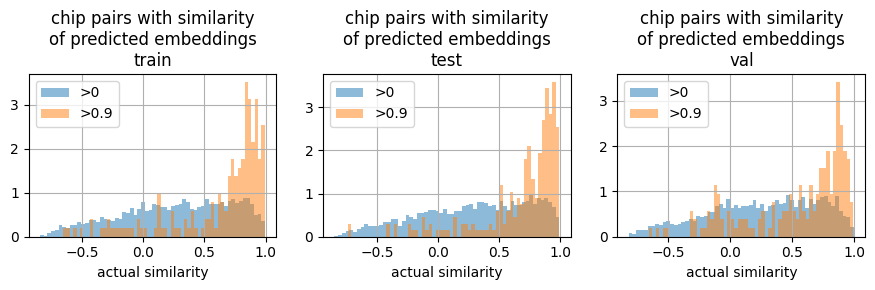

In [35]:
targets, predictions = tr_targets, tr_predictions

for ax, i in subplots(3):
    if i==0: targets, predictions, split_name = tr_targets, tr_predictions, "train"
    if i==1: targets, predictions, split_name = ts_targets, ts_predictions, "test" 
    if i==2: targets, predictions, split_name = val_targets, val_predictions, "val"


    r = []
    for _ in pbar(range(10000)):
        i1,i2 = np.random.permutation(len(targets))[:2]
        simt = similarity(targets[i1], targets[i2])
        simp = similarity(targets[i1], predictions[i2])
        r.append([simt, simp])
    r = np.r_[r]
    r = pd.DataFrame(r, columns=['sim', 'sim_osmencoder'])
    
    thr = 0.9
    for thr in [0, 0.9]:
        rr = r[r['sim_osmencoder']>thr]
        plt.hist(rr['sim'], bins=60, density=True, alpha=.5, label=f">{thr}");
    plt.title(f"chip pairs with similarity\nof predicted embeddings\n{split_name}")
    plt.xlabel("actual similarity")
    plt.grid()
    plt.legend();

Text(0, 0.5, 'a-similarity')

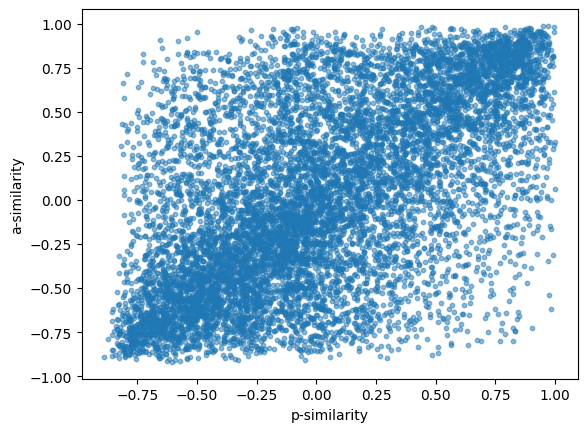

In [36]:
plt.scatter(r['sim'], r['sim_osmencoder'], s=10, alpha=.5)
plt.xlabel("p-similarity")
plt.ylabel("a-similarity")

In [39]:
tr_inputs.shape

(72268, 297)